# Tool-less Agentic System Demo

This script demonstrates a minimal agentic AI experiment using the DepMap PRISM IC50 dataset.
Actual experimental runs will use the exact same workflow:
- with tools
- with better (larger) langauge models
- and across more drugs within the same cell line or across multiple cell lines.

### Overview
- **Data Source**: Preprocessed PRISM secondary drug repurposing dataset (`processed_depmap_prism_ic50.csv`).  
- **Lookup & Dispatch**:  
  - `PrismLookup` retrieves IC50 values by drug and cell line identifiers.  
  - `PrismDispatchQueue` sequentially dispatches drug–cell line prediction tasks with optional shuffling.  
- **Agent**:  
  - A `dspy.Predict` agent configured with `PredictIC50DrugCell` signature.  
  - Operates without external tools (tool-less mode).  
  - Only makes predictions on the first 100 drugs and uses the smaller `openai/gpt-5-nano` model to reduce API usage.
- **Logging**:  
  - Each dispatched prediction is wrapped in a `TraceUnit`.  
  - Results (IC50 prediction, confidence, explanation, trajectory) are logged to JSONL under `analysis/log/toolless/<CCLE_NAME>/`.

### Purpose
This demo provides a reproducible entry point for experimenting with agentic prediction pipelines in a **lab-in-the-loop (LITL)** context. It establishes the foundation for more advanced experiments involving tool integration and reflection.


In [1]:
import subprocess
from collections import OrderedDict
from pathlib import Path
import yaml
import os

import pandas as pd
import dspy
import matplotlib.pyplot as plt

from dspy_litl_agentic_system.tasks.prism_lookup import PrismLookup
from dspy_litl_agentic_system.tasks.task_dispatcher import PrismDispatchQueue
from dspy_litl_agentic_system.agent.signatures import PredictIC50DrugCell
from dspy_litl_agentic_system.agent.trace_unit import TraceUnit
from dspy_litl_agentic_system.utils.jsonl_log import append_jsonl

### Parameters

In [2]:
N = 100 # for low API usage during demo
EXPERIMENTAL_DESCRIPTION = """
    The chemcial-peturbation viability screen is conducted in a 8-step, 
    4-fold dilution, starting from 10μM.
    """ # Adapted from PRISM description
UNIT = 'uM' # PRISM standard unit

CCLE_NAME = "HUCCT1_BILIARY_TRACT" # an arbitrary cell line for demo
SHUFFLE_QUEUE = True
SHUFFLE_SEED = 42
LM_CONFIG = {
    "model": "openai/gpt-5-nano", # small model for demo
    "temperature": 1.0,
    "max_tokens": 20000,
    "seed": 42
}

### Processed Data and Logging path

In [3]:
git_root = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], text=True
).strip()

all_data_path = Path(git_root) \
    / "data" / "processed" / "processed_depmap_prism_ic50.csv"
prism_all_data = pd.read_csv(all_data_path)

log_path = Path(git_root) \
    / "analysis" / "log" / "toolless" / CCLE_NAME
log_path.mkdir(parents=True, exist_ok=True) 

### Validate Global Configurations

In [4]:
# --- Step 1: Locate repo root and config file ---
git_root = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], text=True
).strip()
config_path = Path(git_root) / "config.yml"

if not config_path.exists():
    raise FileNotFoundError(f"Config file not found at: {config_path}")

# --- Step 2: Load config.yml ---
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

# --- Step 3: Validate api section ---
api_cfg = config.get("api")
if not api_cfg:
    raise ValueError("Missing 'api' section in config.yml")

# Required keys
required = {"openai": "OPENAI_API_KEY"}

# --- Step 4: Collect resolved paths ---
results = []
errors = []  # collect problems for later
for req, environ_var in required.items():
    value = api_cfg.get(req, None)
    if value is None:
        results.append((req, None, "Missing in config"))
        errors.append(f"Config '{req}' is missing")
        continue
    key = value.get('key', None)
    if key is None:
        raise ValueError(f"Missing 'key' for '{req}' in config.yml")
    else:
        os.environ[environ_var] = key

### Initialize LooUp and Dispatcher class

In [5]:
lookup = PrismLookup(
    prism_all_data,
    drug_col="name",
    cell_col="ccle_name",
    ic50_col="ic50",
    casefold=False,
    validate_unique=True,
)
subset_lookup = lookup.subset(f"ccle_name == '{CCLE_NAME}'")
print(f"Subset size: {len(subset_lookup)}")

dispatcher = PrismDispatchQueue(
    subset_lookup,
    shuffle=True, # order of drugs is shuffled
    seed=42 # but reproducibile
)
dispatcher.has_next()

Subset size: 778


True

### Initialize LM 

In [6]:
dspy.configure(
    lm=dspy.LM(
        **LM_CONFIG
    ))
agent = dspy.Predict(
    PredictIC50DrugCell,
    tools=[]
)

### Loop across the subset of drugs and predict IC50 values

In [7]:
_n = min(N, dispatcher.remaining)

representation = f"step={_n};ccle={CCLE_NAME};shuffle={SHUFFLE_QUEUE};" \
                 f"seed={SHUFFLE_SEED};"
representation += ';'.join(f"{key}={val}" \
                           for key, val in LM_CONFIG.items()).replace('/', '_')

log_file = log_path / f"{representation}.jsonl"
trace = OrderedDict()

for i in range(_n):

    dispatch_item = dispatcher.dispatch()
    trace_unit = TraceUnit(
        drug=dispatch_item.drug,
        cell_line=dispatch_item.cell,
        experimental_description=EXPERIMENTAL_DESCRIPTION,
        output_unit=UNIT,
        ic50_true=dispatch_item.ic50
    )
    
    result = agent(
        drug=trace_unit.drug,
        cell_line=trace_unit.cell_line,
        experimental_description=trace_unit.experimental_description,
        output_unit=trace_unit.output_unit
    )

    trace_unit.ic50_pred = result.ic50_pred
    trace_unit.confidence = result.confidence
    trace_unit.explanation = result.explanation
    trace_unit.trajecory = result.trajectory if hasattr(result, 'trajectory') \
        else None

    trace[trace_unit.drug] = trace_unit
    
    # Log after each step for validation
    append_jsonl(log_file, record=trace_unit.model_dump())
    
    print(f"Processed {i+1}/{_n}: {trace_unit.drug}")

Processed 1/100: barasertib-HQPA
Processed 2/100: EVP4593
Processed 3/100: WAY-170523
Processed 4/100: entinostat
Processed 5/100: ONX-0914
Processed 6/100: CGS-20625
Processed 7/100: telatinib
Processed 8/100: WAY-600
Processed 9/100: SB-431542
Processed 10/100: cisplatin
Processed 11/100: axitinib
Processed 12/100: benzethonium
Processed 13/100: WHI-P154
Processed 14/100: MEK162
Processed 15/100: cycloheximide
Processed 16/100: etoposide
Processed 17/100: bardoxolone-methyl
Processed 18/100: ercalcitriol
Processed 19/100: tazemetostat
Processed 20/100: SGI-1027
Processed 21/100: prednisolone
Processed 22/100: R406
Processed 23/100: talmapimod
Processed 24/100: SDZ-WAG-994
Processed 25/100: oligomycin-a
Processed 26/100: pralatrexate
Processed 27/100: LDN-212854
Processed 28/100: brequinar
Processed 29/100: aurora-a-inhibitor-i
Processed 30/100: adarotene
Processed 31/100: NSC-319726
Processed 32/100: digoxin
Processed 33/100: efonidipine-monoethanolate
Processed 34/100: AP1903
Proces

### Compute fold error and plot

As anticipated, our agent, without any external tools and memory, does not display improved predictive performance over iterations.

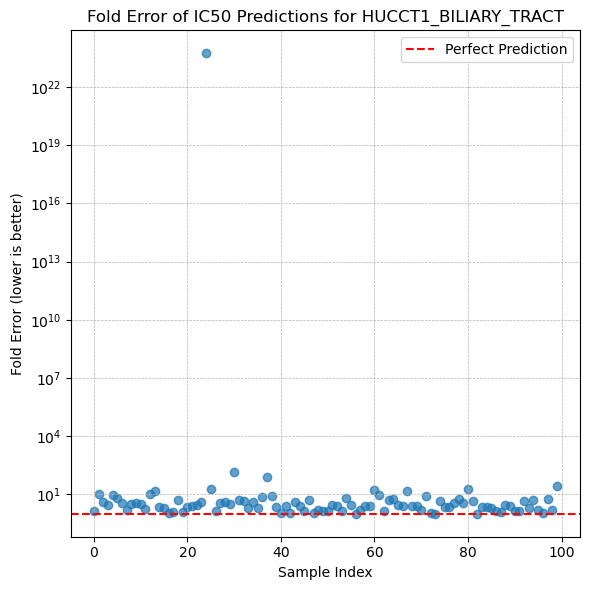

In [8]:
fold_errs = []
eps = 1e-10
for _, trace_unit in trace.items():
    
    fold_errs.append(
        max(
            trace_unit.ic50_pred / (trace_unit.ic50_true + eps),
            trace_unit.ic50_true / (trace_unit.ic50_pred + eps)
        )
    )

plt.figure(figsize=(6,6))
plt.scatter(
    x=range(len(fold_errs)),
    y=fold_errs,
    alpha=0.7
)
plt.yscale('log')
plt.axhline(y=1, color='r', linestyle='--', label='Perfect Prediction')
plt.xlabel('Sample Index')
plt.ylabel('Fold Error (lower is better)')
plt.title(f'Fold Error of IC50 Predictions for {CCLE_NAME}')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()